In [79]:
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # ESTA LINEA SE USA
import networkx as nx
import numpy as np
import pandas as pd
import os
# import geopandas as gpd
import requests  # Para obtener los datos directamente desde la página
# import recursos as recs # estructuras de datos y funciones (los saqué para que no ocupen espacio en el notebook)
# import scipy
import seaborn as sns
import seaborn.objects as so

from io import BytesIO # Para convertir el excel
from pathlib import Path


In [80]:
from mpl_toolkits.basemap import Basemap  # Librería del mapa

# **Preparación de los datos**

## Descarga

In [81]:
# Descargo el documento
url = 'https://www.un.org/development/desa/pd/sites/www.un.org.development.desa.pd/files/undesa_pd_2024_ims_stock_by_sex_destination_and_origin.xlsx'
headers = {'User-Agent': 'Mozilla/5.0'}
respuesta = requests.get(url, headers=headers)
doc_excel = BytesIO(respuesta.content)

# Obtengo y ordeno los datos
migraciones = pd.read_excel(doc_excel, sheet_name='Table 1') # Me quedo solo con la primer plantilla
migraciones = migraciones.iloc[9:, :15].reset_index(drop=True) # Me con las filas donde están realmente los datos (ambos sexos, sin deglose)
migraciones.columns = migraciones.iloc[0].astype(str) # Asigno la primer fila como encabezado
migraciones = (
    migraciones[1:].reset_index(drop=True) # Elimino la fila y limpio los nombres de la columnas
    .rename(
        columns = {col : f'{col[:-2]}' for col in migraciones.columns if col.endswith('.0')}
    )
)

for col in migraciones.columns: # Convierto los datos de las columnas de años a enteros
    if col.isdigit():
        migraciones[col] = migraciones[col].astype('Int64').fillna(0) # Reemplazo con cero los datos faltante

columnas_de_interes = [ # Conservo los codigos de paises/regiones (para facilitar la exploración)
    'Location code of origin',
    'Region, development group, country or area of origin',
    'Location code of destination',
    'Region, development group, country or area of destination',
    '1990','1995','2000','2005','2010','2015','2020','2024',
]
migraciones = (
    migraciones[columnas_de_interes].rename(
        columns = {
            'Location code of origin': 'codigo_origen',
            'Region, development group, country or area of origin': 'origen',
            'Location code of destination': 'codigo_destino',
            'Region, development group, country or area of destination': 'destino',
        }
    )
)
migraciones.head()

,codigo_origen,origen,codigo_destino,destino,1990,1995,2000,2005,2010,2015,2020,2024
0,900,World,900,World,153916063,163176002,174566152,192788721,221020392,250042020,275284032,304021813
1,1834,Sub-Saharan Africa,900,World,14124662,15183742,14584913,16004417,18243295,22763602,27134957,30661610
2,1833,Northern Africa and Western Asia,900,World,14986109,17216219,18728264,21198002,25429492,32508087,37196853,40529326
3,1831,Central and Southern Asia,900,World,30342957,27930630,30008559,32445580,39400759,46011893,48594959,53948417
4,1832,Eastern and South-Eastern Asia,900,World,14465509,17262816,20822011,24315849,30053666,34562856,38223520,41409235


In [82]:
migraciones = migraciones.dropna()
# Eliminar espacios y asteriscos finales en 'origen' y 'destino'
migraciones['origen'] = migraciones['origen'].str.strip().str.replace(r'\*$', '', regex=True)
migraciones['destino'] = migraciones['destino'].str.strip().str.replace(r'\*$', '', regex=True)

In [83]:
migraciones["destino"].unique()

array(['World', 'Sub-Saharan Africa', 'Northern Africa and Western Asia',
       'Central and Southern Asia', 'Eastern and South-Eastern Asia',
       'Latin America and the Caribbean',
       'Oceania (excluding Australia and New Zealand)',
       'Australia/New Zealand', 'Europe and Northern America',
       'More developed regions', 'Less developed regions',
       'Least developed countries',
       'Less developed regions, excluding least developed countries',
       'Less developed regions, excluding China',
       'Land-locked Developing Countries (LLDC)',
       'Small Island Developing States (SIDS)',
       'High-and-upper-middle-income countries',
       'Low-and-Lower-middle-income countries', 'High-income countries',
       'Low-and-middle-income countries', 'Middle-income countries',
       'Upper-middle-income countries', 'Lower-middle-income countries',
       'Low-income countries', 'No income group available', 'AFRICA',
       'Eastern Africa', 'Burundi', 'Comoros', '

## Coordenadas de paises

In [84]:
colores = [  # Para identificar las aristas o nodos (por ahora se eligen al azar pero se podrían asignar)
    "#004d03","#5f33de","#51bf00","#a754ff","#00be3b","#ff4ef2","#85bd00","#48009e","#caad00","#3764ff",
    "#e79b00","#0129af","#f37200","#3095ff","#ff2d1d","#00a9fe","#ea0020","#00bd8d","#fb00c5","#00ae68",
    "#9d0095","#a9cd75","#ff54c7","#385d00","#7489ff","#927e00","#d190ff","#666e00","#730066","#ccc46b",
    "#001b52","#ff113f","#01b4b0","#ff5141","#01adcd","#be4300","#0059a4","#ff884a","#0182b6","#9a1400",
    "#59d4ca","#b20067","#007e54","#ff6285","#003a0b","#ff7eb2","#016f54","#ff7e79","#001804","#ff9ed6",
    "#004839","#ffa67d","#180025","#e1bc85","#59003d","#b2c8a7","#830039","#006467","#ad5a00","#016295",
    "#7c5300","#bcbcfd","#622000","#bac1d9","#330300","#e1b5d1","#3e2e00","#d3bdb9","#004052","#f4b29d",
    "#b60004","#05bc3c","#8e11a8","#cbc000","#2050da","#99ac00","#7535c1","#b6cc52","#ab6dfe","#007c1c",
    "#e24cd4","#01a85a","#da009b","#3ada9a","#aa008d","#548100","#3f7dff","#ffa825","#0045b2","#f07100",
    "#014eac","#b29000","#573395","#9fd073","#c4005a","#6dd5a2","#ff3948","#00c4dd","#d5380a","#02bafd",
    "#9e1c00","#01a5a2","#bf0036","#018d67","#ff6096","#005719","#ffa2f4","#4b5800","#b49dff","#cb7100",
    "#015998","#bb7c00","#60367d","#95d187","#782c5c","#e6bc5d","#414479","#ff9652","#01566f","#a65300",
    "#b4b8ff","#873600","#8fceb9","#8a2115","#acc9b2","#7d2f29","#dabe87","#3e4863","#ff7f74","#365027",
    "#ff8bc3","#814e00","#f3add5","#614226","#ddb7cb","#594c40","#ffa187","#5e404c","#f5b0b0","#98827d"
]

coordenadas = {
    'Burundi': (-3.3731, 29.9189),
    'Comoros': (-11.7085, 43.2547),
    'Djibouti': (11.8251, 42.5903),
    'Eritrea': (15.1794, 39.7823),
    'Ethiopia': (9.145, 40.4897),
    'Kenya': (-1.2921, 36.8219),
    'Madagascar': (-18.8792, 47.5079),
    'Malawi': (-13.2543, 34.3015),
    'Mauritius': (-20.348404, 57.552152),
    'Mayotte': (-12.8275, 45.166244),
    'Mozambique': (-25.9653, 32.5892),
    'Réunion': (-21.1151, 55.5364),
    'Rwanda': (-1.9403, 29.8739),
    'Seychelles': (-4.6796, 55.492),
    'Somalia': (2.0469, 45.3182),
    'South Sudan': (6.8769, 31.3069),
    'Uganda': (1.3733, 32.2903),
    'United Republic of Tanzania': (-6.369028, 34.888822),
    'Zambia': (-13.1339, 27.8493),
    'Zimbabwe': (-19.0158, 29.1549),
    'Angola': (-9.1895, 17.8739),
    'Cameroon': (3.848, 11.5021),
    'Central African Republic': (4.3947, 18.5582),
    'Chad': (12.1348, 15.0557),
    'Congo': (-4.4419, 15.2663),
    'Democratic Republic of the Congo': (-4.4419, 15.2663),
    'Equatorial Guinea': (1.6508, 10.2679),
    'Gabon': (-0.8037, 11.6094),
    'Sao Tome and Principe': (0.1864, 6.6131),
    'Algeria': (28.0339, 1.6596),
    'Egypt': (26.8206, 30.8025),
    'Libya': (26.3351, 17.2283),
    'Morocco': (31.7917, -7.0926),
    'Sudan': (12.8628, 30.2176),
    'Tunisia': (33.8869, 9.5375),
    'Botswana': (-22.3285, 24.6849),
    'Eswatini': (-26.5225, 31.4659),
    'Lesotho': (-29.6091, 28.2336),
    'Namibia': (-22.9576, 18.4904),
    'South Africa': (-30.5595, 22.9375),
    'Benin': (9.3075, 2.3158),
    'Burkina Faso': (12.2383, -1.5616),
    'Cabo Verde': (16.002082, -24.013197),
    "Côte d'Ivoire": (7.539989, -5.547080),
    'Gambia': (13.4432, -15.3101),
    'Ghana': (7.9465, -1.0232),
    'Guinea': (9.9456, -9.6966),
    'Guinea-Bissau': (11.8037, -15.1804),
    'Liberia': (6.4281, -9.4295),
    'Mali': (17.5707, -3.9962),
    'Mauritania': (21.0079, -10.9408),
    'Niger': (17.6078, 8.0817),
    'Nigeria': (9.082, 8.6753),
    'Saint Helena': (-15.965, -5.7089),
    'Senegal': (14.6928, -17.4467),
    'Sierra Leone': (8.4606, -11.7799),
    'Togo': (8.6195, 0.8248),
    'Kazakhstan': (48.0196, 66.9237),
    'Kyrgyzstan': (41.2044, 74.7661),
    'Tajikistan': (38.8610, 71.2761),
    'Turkmenistan': (38.9697, 59.5563),
    'Uzbekistan': (41.3775, 64.5853),
    'China': (35.8617, 104.1954),
    'China, Hong Kong SAR': (22.3193, 114.1694),
    'China, Macao SAR': (22.1987, 113.5439),
    'China, Taiwan Province of China': (23.6978, 120.9605),
    "Dem. People's Republic of Korea": (40.3399, 127.5101),
    'Japan': (36.2048, 138.2529),
    'Mongolia': (46.8625, 103.8467),
    'Republic of Korea': (35.9078, 127.7669),
    'Afghanistan': (33.9391, 67.7100),
    'Bangladesh': (23.685, 90.3563),
    'Bhutan': (27.5142, 90.4336),
    'India': (20.5937, 78.9629),
    'Iran (Islamic Republic of)': (32.4279, 53.6880),
    'Maldives': (3.2028, 73.2207),
    'Nepal': (28.3949, 84.1240),
    'Pakistan': (30.3753, 69.3451),
    'Sri Lanka': (7.8731, 80.7718),
    'Brunei Darussalam': (4.5353, 114.7277),
    'Cambodia': (12.5657, 104.9910),
    'Indonesia': (-0.7893, 113.9213),
    "Lao People's Democratic Republic": (19.8563, 102.4955),
    "Malaysia": (4.2105, 101.9758),
    "Myanmar": (21.9162, 95.955974),
    "Philippines": (12.8797, 121.7740),
    "Singapore": (1.3521, 103.8198),
    "Thailand": (15.8700, 100.9925),
    "Timor-Leste": (-8.8742, 125.7275),
    "Viet Nam": (14.0583, 108.2772),
    "Armenia": (40.0691, 45.0382),
    "Azerbaijan": (40.1431, 47.5769),
    "Bahrain": (26.0667, 50.5577),
    "Cyprus": (35.1264, 33.4299),
    "Georgia": (42.3154, 43.3569),
    "Iraq": (33.2232, 43.6793),
    "Israel": (31.0461, 34.8516),
    "Jordan": (30.5852, 36.2384),
    "Kuwait": (29.3759, 47.9774),
    "Lebanon": (33.8547, 35.8623),
    "Oman": (21.5126, 55.9233),
    "Qatar": (25.3548, 51.1839),
    "Saudi Arabia": (23.8859, 45.0792),
    "State of Palestine": (31.9474, 35.2272),
    "Syrian Arab Republic": (34.8021, 38.9968),
    "Türkiye": (38.9637, 35.2433),
    "United Arab Emirates": (23.4241, 53.8478),
    "Yemen": (15.5527, 48.5164),
    "Belarus": (53.7098, 27.9534),
    "Bulgaria": (42.7339, 25.4858),
    "Czechia": (49.8175, 15.4730),
    "Hungary": (47.1625, 19.5033),
    "Poland": (51.9194, 19.1451),
    "Republic of Moldova": (47.4116, 28.3699),
    "Romania": (45.9432, 24.9668),
    "Russian Federation": (61.5240, 105.3188),
    "Slovakia": (48.6690, 19.6990),
    "Ukraine": (48.3794, 31.1656),
    "Channel Islands": (49.4657, -2.5851),
    "Denmark": (56.2639, 9.5018),
    "Estonia": (58.5953, 25.0136),
    "Faroe Islands": (61.8926, -6.9118),
    "Finland": (61.9241, 25.7482),
    "Iceland": (64.9631, -19.0208),
    "Ireland": (53.4129, -8.2439),
    "Isle of Man": (54.2361, -4.5481),
    "Latvia": (56.8796, 24.6032),
    "Lithuania": (55.1694, 23.8813),
    "Norway": (60.4720, 8.4689),
    "Sweden": (60.1282, 18.6435),
    "United Kingdom": (55.3781, -3.4360),
    "Albania": (41.1533, 20.1683),
    "Andorra": (42.5462, 1.6016),
    "Bosnia and Herzegovina": (43.9159, 17.6791),
    "Croatia": (45.1000, 15.2000),
    "Gibraltar": (36.1408, -5.3536),
    "Greece": (39.0742, 21.8243),
    "Holy See": (41.9029, 12.4534),
    "Italy": (41.8719, 12.5674),
    "Malta": (35.9375, 14.3754),
    "Montenegro": (42.7087, 19.3744),
    "North Macedonia": (41.6086, 21.7453),
    "Portugal": (39.3999, -8.2245),
    "San Marino": (43.9336, 12.4578),
    "Serbia": (44.0165, 21.0059),
    "Slovenia": (46.1512, 14.9955),
    "Spain": (40.4637, -3.7492),
    "Austria": (47.5162, 14.5501),
    "Belgium": (50.8333, 4.0),
    "France": (46.2276, 2.2137),
    "Germany": (51.1657, 10.4515),
    "Liechtenstein": (47.1660, 9.5554),
    "Luxembourg": (49.8153, 6.1296),
    "Monaco": (43.7384, 7.4246),
    "Netherlands": (52.1326, 5.2913),
    "Switzerland": (46.8182, 8.2275),
    "Anguilla": (18.2206, -63.0686),
    "Antigua and Barbuda": (17.0608, -61.7964),
    "Aruba": (12.5211, -69.9683),
    "Bahamas": (25.0343, -77.3963),
    "Barbados": (13.1939, -59.5432),
    "Bonaire": (12.1784, -68.2385),
    "Sint Eustatius and Saba": (17.4890, -62.9780),
    "British Virgin Islands": (18.4207, -64.6399),
    "Cayman Islands": (19.3133, -81.2546),
    "Cuba": (21.5218, -77.7812),
    "Curaçao": (12.1696, -68.9900),
    "Dominica": (15.4150, -61.3710),
    "Dominican Republic": (18.7357, -70.1627),
    "Grenada": (12.1165, -61.6790),
    "Guadeloupe": (16.2650, -61.5510),
    "Haiti": (18.9712, -72.2852),
    "Jamaica": (18.1096, -77.2975),
    "Martinique": (14.6415, -61.0242),
    "Montserrat": (16.7425, -62.1874),
    "Puerto Rico": (18.2208, -66.5901),
    "Saint Kitts and Nevis": (17.3578, -62.782998),
    "Saint Lucia": (13.9094, -60.9789),
    "Saint Vincent and the Grenadines": (12.9843, -61.2872),
    "Sint Maarten (Dutch part)": (18.0425, -63.0548),
    "Trinidad and Tobago": (10.6918, -61.2225),
    "Turks and Caicos Islands": (21.6940, -71.7979),
    "United States Virgin Islands": (18.3358, -64.8963),
    "Belize": (17.1899, -88.4976),
    "Costa Rica": (9.7489, -83.7534),
    "El Salvador": (13.7942, -88.8965),
    "Guatemala": (15.7835, -90.2308),
    "Honduras": (15.2000, -86.2419),
    "Mexico": (23.6345, -102.5528),
    "Nicaragua": (12.8654, -85.2072),
    "Panama": (8.5379, -80.7821),
    "Argentina": (-38.4161, -63.6167),
    "Bolivia (Plurinational State of)": (-16.2902, -63.5887),
    "Brazil": (-14.2350, -51.9253),
    "Chile": (-35.6751, -71.5430),
    "Colombia": (4.5709, -74.2973),
    "Ecuador": (-1.8312, -78.1834),
    "Falkland Islands (Malvinas)": (-51.7963, -59.5236),
    "French Guiana": (3.9339, -53.1258),
    "Guyana": (4.8604, -58.9302),
    "Paraguay": (-23.4425, -58.4438),
    "Peru": (-9.189967, -75.0152),
    "Suriname": (3.9193, -56.0278),
    "Uruguay": (-32.5228, -55.7658),
    "Venezuela (Bolivarian Republic of)": (6.4238, -66.5897),
    "Bermuda": (32.3078, -64.7505),
    "Canada": (56.1304, -106.3468),
    "Greenland": (71.7069, -42.6043),
    "Saint Pierre and Miquelon": (46.9419, -56.2711),
    "United States of America": (37.0902, -95.7129),
    "Australia": (-25.2744, 133.7751),
    "New Zealand": (-40.9006, 174.8860),
    "Melanesia": (-8.7832, 160.7000),
    "Fiji": (-17.7134, 178.0650),
    "New Caledonia": (-20.9043, 165.6180),
    "Papua New Guinea": (-6.3149, 143.9555),
    "Solomon Islands": (-9.6457, 160.1562),
    "Vanuatu": (-15.3767, 166.9592),
    "Guam": (13.4443, 144.7937),
    "Kiribati": (1.8709, -157.3630),
    "Marshall Islands": (7.1315, 171.1845),
    "Micronesia (Fed. States of)": (7.4256, 150.5508),
    "Nauru": (-0.5228, 166.9315),
    "Northern Mariana Islands": (17.3308, 145.3849),
    "Palau": (7.5149, 134.5825),
    "American Samoa": (-14.2706, -170.1322),
    "Cook Islands": (-21.2367, -159.7777),
    "French Polynesia": (-17.6797, -149.4068),
    "Niue": (-19.0544, -169.8672),
    "Samoa": (-13.7590, -172.1046),
    "Tokelau": (-9.2002, -171.8480),
    "Tonga": (-21.1789, -175.1982),
    "Tuvalu": (-7.1095, 177.6493),
    "Wallis and Futuna Islands": (-13.7688, -177.1561),
}
for pais,coord in coordenadas.items():
    coordenadas[pais] = (coord[1], coord[0], colores[np.random.randint(139)]) # Le agregué un color a cada país

In [85]:
import numpy as np

arr = migraciones["origen"].unique() # verifiqué tanto origen como destino
no_encontrados = [nombre for nombre in arr if nombre not in coordenadas]

print("Regiones no encontradas en el diccionario:")
for n in no_encontrados:
    print("   ", n)

Regiones no encontradas en el diccionario:
    World
    Sub-Saharan Africa
    Northern Africa and Western Asia
    Central and Southern Asia
    Eastern and South-Eastern Asia
    Latin America and the Caribbean
    Oceania (excluding Australia and New Zealand)
    Australia/New Zealand
    Europe and Northern America
    More developed regions
    Less developed regions
    Least developed countries
    Less developed regions, excluding least developed countries
    Less developed regions, excluding China
    Land-locked Developing Countries (LLDC)
    Small Island Developing States (SIDS)
    High-and-upper-middle-income countries
    Low-and-Lower-middle-income countries
    High-income countries
    Low-and-middle-income countries
    Middle-income countries
    Upper-middle-income countries
    Lower-middle-income countries
    Low-income countries
    No income group available
    AFRICA
    Eastern Africa
    Middle Africa
    Northern Africa
    Western Sahara
    Southern Af

## Acá es donde disminuye unicamente a países, sin regiones. 

In [86]:
migra_paises = ( # Me quedo solo con las filas de paises que estan como claves en el diccionario de coordenadas
    migraciones[ migraciones['origen'].isin(coordenadas.keys()) & migraciones['destino'].isin(coordenadas.keys())]
    .reset_index(drop=True)
)
migra_paises.head()

,codigo_origen,origen,codigo_destino,destino,1990,1995,2000,2005,2010,2015,2020,2024
0,404,Kenya,108,Burundi,186,216,202,502,847,1032,1226,1377
1,646,Rwanda,108,Burundi,221943,160197,66415,61104,54794,64363,76567,85969
2,800,Uganda,108,Burundi,1833,1546,949,805,731,891,1058,1188
3,834,United Republic of Tanzania,108,Burundi,11912,9780,5692,13732,22974,28008,33318,37409
4,180,Democratic Republic of the Congo,108,Burundi,36654,41447,37951,99099,147611,175768,199585,224091


## Grafos de prueba

### Función para graficar grafos

In [87]:
def dibujar_grafo_continente(
    G,
    titulo:str,
    medidas:tuple[int,int],
    color_fondo:str,
    pos_nodos:dict[str, tuple],
    tam_nodos:int,
    tam_tex_nodos:int,
    color_nodos:str,
    color_tex_nodos:str,
    color_aristas:str,
    color_tex_aristas:str,
    color_fondo_tex_aristas:str,
    tam_tex_aristas:int,
    graficar_pesos:bool,
    aristas_con_distinto_grosor:bool,
    continente:str=None,
    rango_grosor_aristas:tuple[int,int]=(1,5),
    nodos_con_distinto_color:bool=False,
    aristas_con_distinto_color:bool=False
):
    from mpl_toolkits.basemap import Basemap
    import matplotlib.patches as mpatches
    import matplotlib.pyplot as plt
    import numpy as np
    import networkx as nx

    fig = plt.figure(figsize=medidas)
    fig.set_facecolor(color_fondo)
    ax = fig.add_subplot(1,1,1)
    ax.set_facecolor(color_fondo)
    ax.axis('off')

    # Límites según continente
    if continente == "Suramérica":
        llcrnrlon, llcrnrlat = -90, -60
        urcrnrlon, urcrnrlat = -30, 15
    elif continente == "Norteamérica":
        llcrnrlon, llcrnrlat = -170, 5
        urcrnrlon, urcrnrlat = -50, 85
    elif continente == "Europa":
        llcrnrlon, llcrnrlat = -30, 35
        urcrnrlon, urcrnrlat = 60, 72
    else:
        llcrnrlon, llcrnrlat = -180, -90
        urcrnrlon, urcrnrlat = 180, 90

    m = Basemap(
        projection='merc',
        llcrnrlon=llcrnrlon,
        llcrnrlat=llcrnrlat,
        urcrnrlon=urcrnrlon,
        urcrnrlat=urcrnrlat,
        resolution='i',
        ax=ax
    )

    m.drawcoastlines(color='gray')
    m.drawcountries(color='gray')
    m.fillcontinents(color='whitesmoke', lake_color='gray')
    m.drawmapboundary(fill_color='gray')

    pos_nodos = {}
    for nodo in G.nodes():
        if nodo in coordenadas:
            lon, lat, _ = coordenadas[nodo]  # <- orden cambiado
            x, y = m(lon, lat)
            pos_nodos[nodo] = (x, y)
    # ----------------------------------------------------------------------------------------------------

    # Dibuja los nodos
    if nodos_con_distinto_color: # Si se elige que tengan distinto color
        color_nodos = [coordenadas[nodo][2] for nodo in G.nodes()]
    nx.draw_networkx_nodes(
        G,
        pos_nodos,
        node_size = tam_nodos,
        node_color = color_nodos,
    )

    # Dibuja las etiquetas de los nodos
    nx.draw_networkx_labels(
        G,
        pos_nodos,
        font_size = tam_tex_nodos,
        font_weight = 'bold',
        font_color = color_tex_nodos
    )

    # Si se indica, defino el grosor de las aristas en función de su peso
    if aristas_con_distinto_grosor:
        pesos = np.array([w['weight'] for _, _, w in G.edges(data=True)])  # Obtengo los pesos
        pesos_log = np.log10(pesos + 1) # Por si algún peso es 1
        grosores = ( # Normalizados al rango
            rango_grosor_aristas[0] + ((rango_grosor_aristas[1] - rango_grosor_aristas[0]) * (pesos_log - pesos_log.min())) /
            (pesos_log.max() - pesos_log.min() + 1e-9) # 1e-9 para prevenir la división por cero
        )
        # Dibujo las aristas
        for (u, v, w), grosor in zip(G.edges(data=True), grosores):
            x1, y1 = pos_nodos[u]
            x2, y2 = pos_nodos[v]
            if aristas_con_distinto_color:
                color_arista = coordenadas[u][2]
            else:
                color_arista = color_aristas
            flecha_args = dict(  # Configuración básica de cada flecha
                posA=(x1, y1),
                posB=(x2, y2),
                connectionstyle='arc3,rad=0',
                arrowstyle='-|>',
                color=color_arista,
                lw=grosor,
                mutation_scale=grosor * 7 # Hago la flecha proporcional
            )
            flecha = mpatches.FancyArrowPatch(**flecha_args)
            ax.add_patch(flecha)

    else:  # Si las aristas no tienen distinto grosor
        if aristas_con_distinto_color: # Si se elige que tengan distinto color
            color_aristas = [coordenadas[u][2] for u, v in G.edges()]
        nx.draw_networkx_edges(
            G,
            pos_nodos,
            edge_color=color_aristas,
            arrows=True,
            arrowstyle='-|>',
            arrowsize=25
        )

    # Si se indicó graficar los pesos
    if graficar_pesos:
        for u, v, w in G.edges(data=True):
            x1, y1 = pos_nodos[u]
            x2, y2 = pos_nodos[v]
            ax.text(
                (x1 + x2) / 2, # En el medio de sus aristas
                (y1 + y2) / 2,
                f"{w['weight']}",
                fontsize = tam_tex_aristas,
                color = color_tex_aristas,
                ha = 'center',
                va = 'center',
                bbox = dict(
                    facecolor=color_fondo_tex_aristas,
                    edgecolor='none'
                )
            )


    plt.title(titulo)
    plt.axis('equal')
    plt.close()
    return fig

## Caso América del Sur

In [88]:
sur_america = [
    "Argentina", "Bolivia (Plurinational State of)", "Brazil", "Chile", "Colombia",
    "Ecuador", "Falkland Islands (Malvinas)", "French Guiana", "Guyana",
    "Paraguay", "Peru", "Suriname", "Uruguay", "Venezuela (Bolivarian Republic of)"
]

In [89]:
migraciones_sur = migraciones[migraciones['origen'].isin(sur_america) & migraciones['destino'].isin(sur_america)]
# Ver todas las filas con la nueva columna
display(migraciones_sur)

,codigo_origen,origen,codigo_destino,destino,1990,1995,2000,2005,2010,2015,2020,2024
24341,68,Bolivia (Plurinational State of),32,Argentina,161850,190118,223303,273555,340770,342431,339423,337017
24342,76,Brazil,32,Argentina,38851,36975,35180,37254,41070,44633,48454,51527
24343,152,Chile,32,Argentina,214148,213391,212646,203538,191797,172916,155359,141348
24344,170,Colombia,32,Argentina,12,12,15,3645,16289,26314,39991,53163
24345,218,Ecuador,32,Argentina,12,14,1049,2905,4680,6197,8066,9704
...,...,...,...,...,...,...,...,...,...,...,...,...
25553,328,Guyana,862,Venezuela (Bolivarian Republic of),4601,5577,6698,7511,8510,9149,8624,8227
25554,600,Paraguay,862,Venezuela (Bolivarian Republic of),359,294,239,226,217,214,200,191
25555,604,Peru,862,Venezuela (Bolivarian Republic of),29635,32973,36348,39846,44126,47007,44319,42281
25556,740,Suriname,862,Venezuela (Bolivarian Republic of),106,80,61,54,48,46,43,41


In [90]:
import networkx as nx

# Instancia del grafo dirigido
grafo_migra_2024 = nx.DiGraph()

# Agrego los vértices y aristas (solo cuando haya migrantes en 2024)
for origen, destino in zip(migraciones_sur['origen'], migraciones_sur['destino']):
    migrantes = migraciones_sur.loc[(migraciones_sur['origen'] == origen) & (migraciones_sur['destino'] == destino),'2024'].sum()
    
    if migrantes != 0:  # Solo agrego casos con migrantes
        grafo_migra_2024.add_node(destino)  # Nodo destino
        grafo_migra_2024.add_edge(
            origen,      # Nodo origen
            destino,     # Nodo destino
            weight=migrantes  # Peso = cantidad de migrantes
        )

# Generar posiciones geográficas para los nodos
pos = {}
for nodo in grafo_migra_2024.nodes():
    x,y,_ = coordenadas[nodo]  # Me quedo solo con la latitud y longitud (descarto el color)
    pos[nodo] = (x,y)

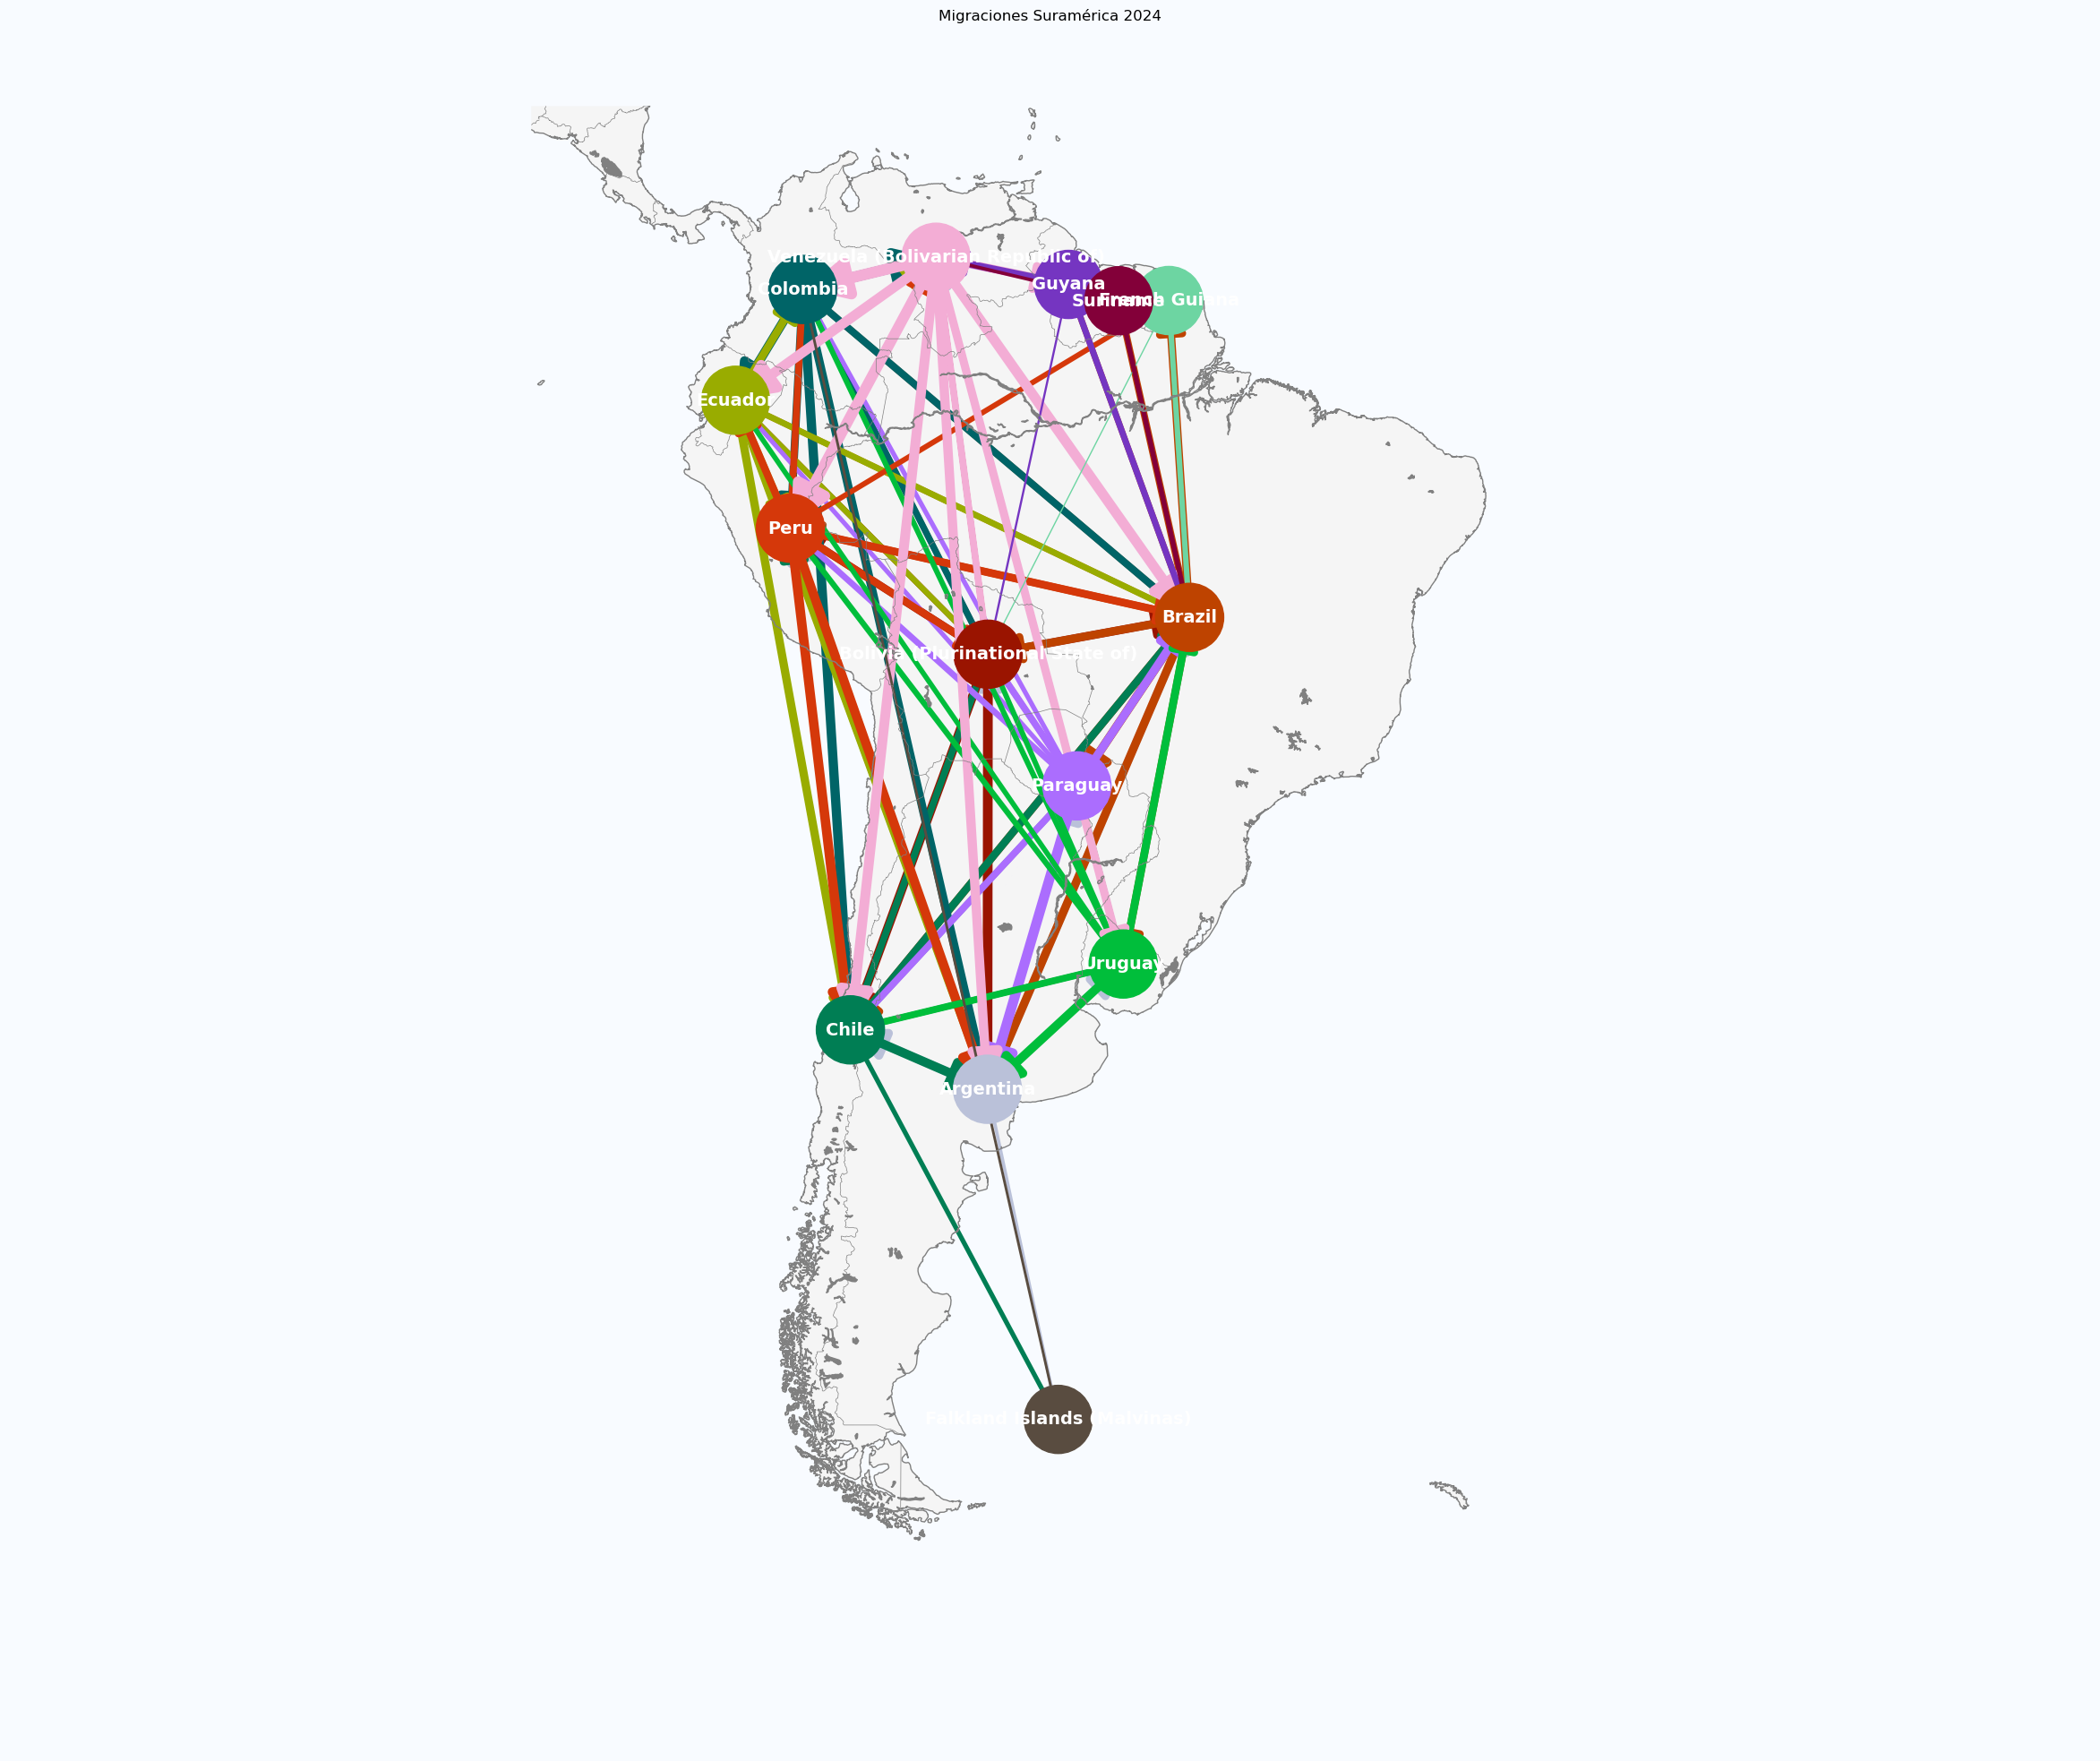

In [91]:
grafo = dibujar_grafo_continente(
    grafo_migra_2024,
    'Migraciones Suramérica 2024',
    (30,25),          # tamaño
    '#f8fbff',        # fondo
    pos,
    3000,             # tamaño base de nodos
    14,               # tamaño del texto de los nodos
    '#a8dadc',        # color de nodos 
    '#ffffff',        # color del texto dentro de nodos 
    '#bcd9ea',        # color de flechas 
    '#4a4a4a',        # color del texto de pesos 
    '#ffffff',        # fondo del texto de pesos
    10,               # tamaño texto aristas
    False,            # mostrar pesos (False = no)
    True,             # grosor variable según peso
    continente="Suramérica",
    rango_grosor_aristas=(1,9),
    nodos_con_distinto_color=True,
    aristas_con_distinto_color=True
)
display(grafo)

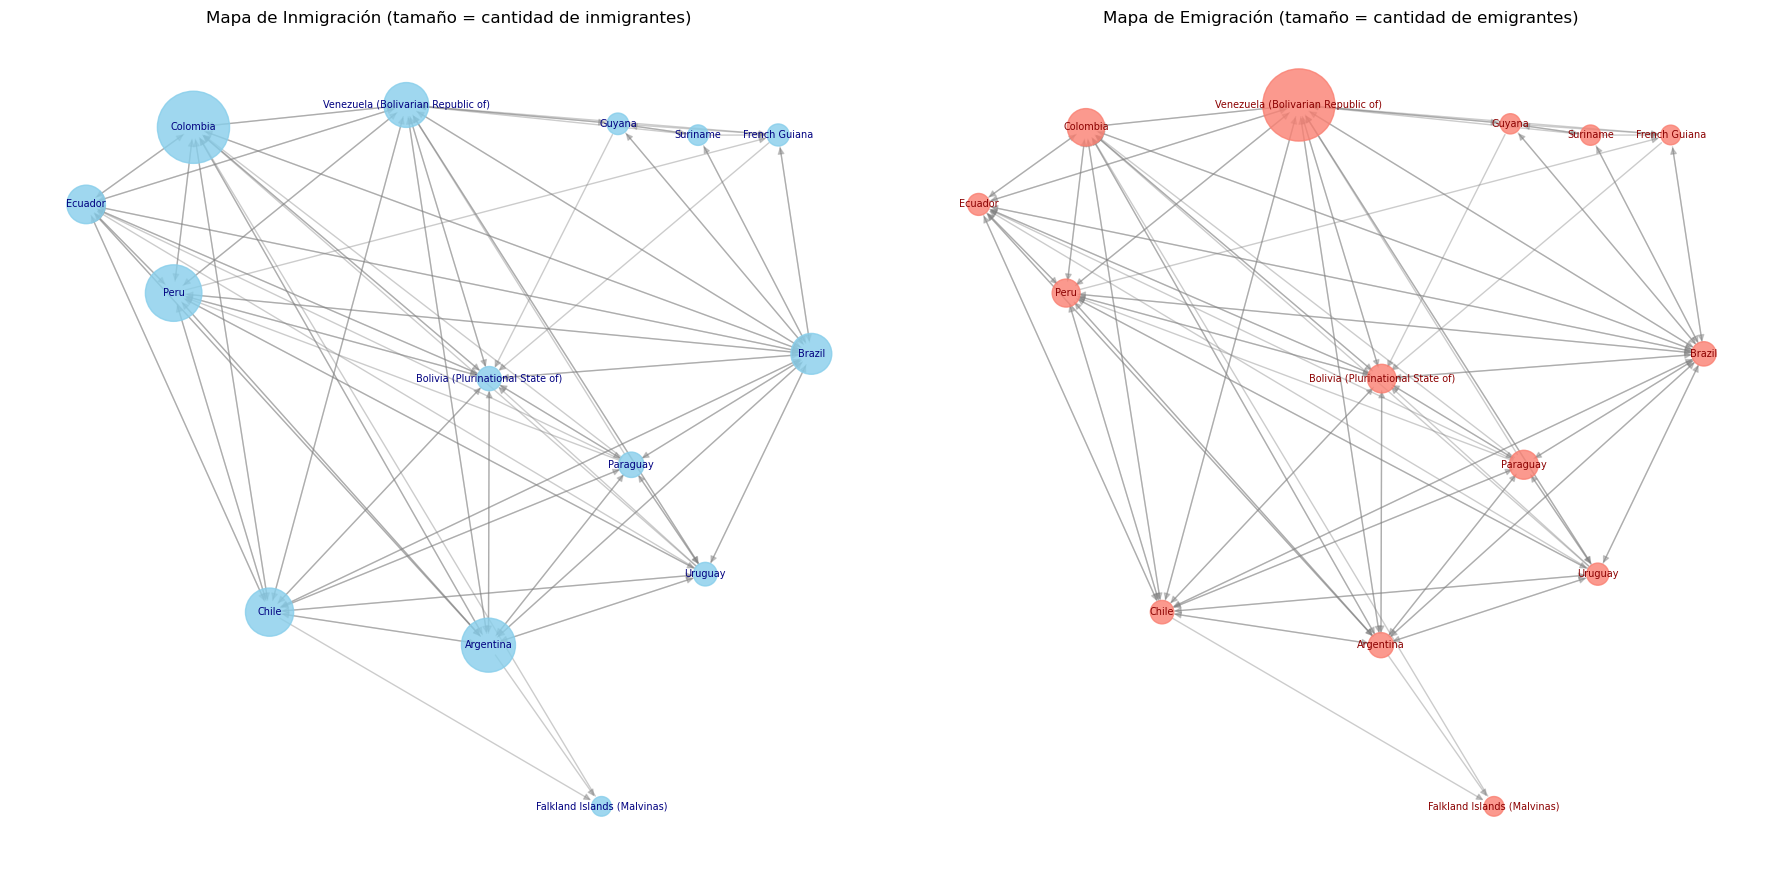

In [92]:
import networkx as nx
import matplotlib.pyplot as plt

grafo_migra_2024 = nx.DiGraph()

for origen, destino in zip(migraciones_sur['origen'], migraciones_sur['destino']):
    migrantes = migraciones_sur.loc[
        (migraciones_sur['origen'] == origen) &
        (migraciones_sur['destino'] == destino),
        '2024'
    ].sum()
    
    if migrantes != 0:
        grafo_migra_2024.add_edge(origen, destino, weight=migrantes)

pos = {nodo: (coordenadas[nodo][0], coordenadas[nodo][1]) for nodo in grafo_migra_2024.nodes()}

inmigracion = {n: sum(d['weight'] for _, _, d in grafo_migra_2024.in_edges(n, data=True))
               for n in grafo_migra_2024.nodes()}
emigracion = {n: sum(d['weight'] for _, _, d in grafo_migra_2024.out_edges(n, data=True))
               for n in grafo_migra_2024.nodes()}

# Escalar tamaños  es como el entre 0 y 1, pero con 200 y 2700 que es el valor recomendado por nodo.
max_in = max(inmigracion.values()) if inmigracion else 1
max_out = max(emigracion.values()) if emigracion else 1
tam_in = [2500 * (inmigracion[n]/max_in) + 200 for n in grafo_migra_2024.nodes()]
tam_out = [2500 * (emigracion[n]/max_out) + 200 for n in grafo_migra_2024.nodes()]

fig, ax = plt.subplots(1, 2, figsize=(18, 9))

# INMIGRACIÓN
nx.draw_networkx_nodes(
    grafo_migra_2024, pos, ax=ax[0],
    node_size=tam_in, node_color='skyblue', alpha=0.8
)
nx.draw_networkx_edges(
    grafo_migra_2024, pos, ax=ax[0],
    alpha=0.4, edge_color='gray',
    arrows=True, arrowsize=10, arrowstyle='-|>'
)
nx.draw_networkx_labels(
    grafo_migra_2024, pos, ax=ax[0],
    labels={n: n for n in grafo_migra_2024.nodes()},
    font_size=7, font_color='navy'
)
ax[0].set_title("Mapa de Inmigración (tamaño = cantidad de inmigrantes)")
ax[0].axis('off')

# EMIGRACIÓN
nx.draw_networkx_nodes(
    grafo_migra_2024, pos, ax=ax[1],
    node_size=tam_out, node_color='salmon', alpha=0.8
)
nx.draw_networkx_edges(
    grafo_migra_2024, pos, ax=ax[1],
    alpha=0.4, edge_color='gray',
    arrows=True, arrowsize=10, arrowstyle='-|>'
)
nx.draw_networkx_labels(
    grafo_migra_2024, pos, ax=ax[1],
    labels={n: n for n in grafo_migra_2024.nodes()},
    font_size=7, font_color='darkred'
)
ax[1].set_title("Mapa de Emigración (tamaño = cantidad de emigrantes)")
ax[1].axis('off')

plt.tight_layout()
plt.show()

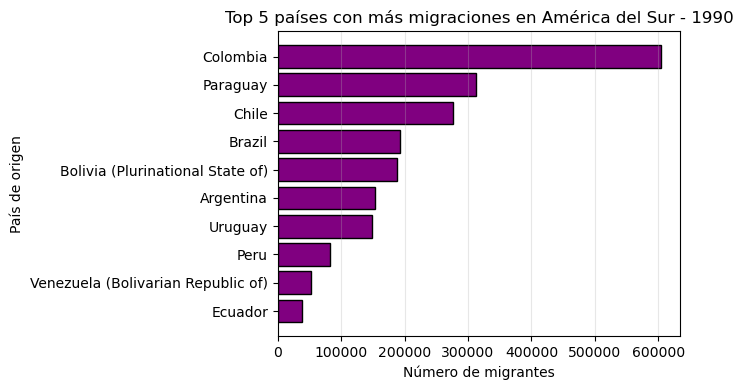

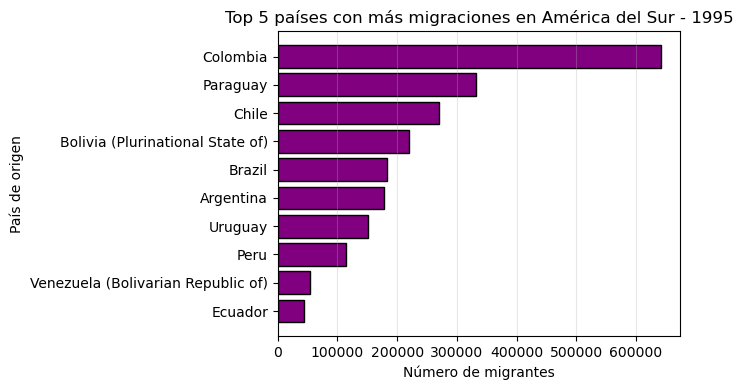

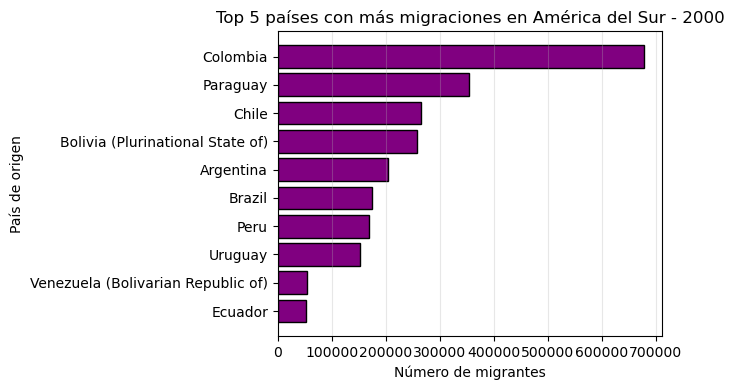

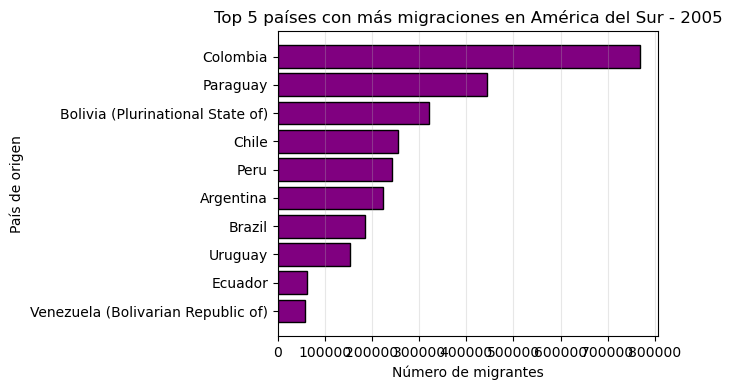

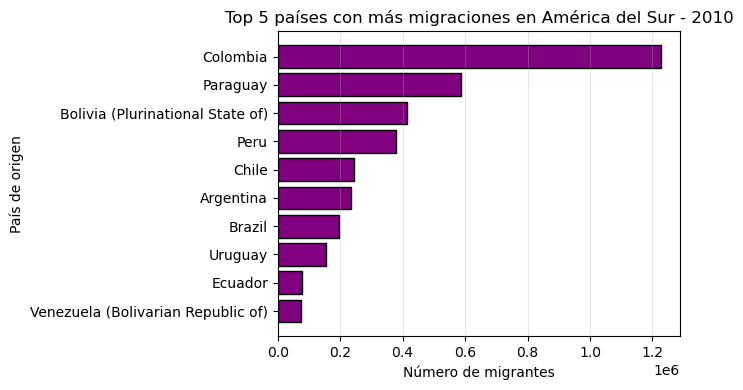

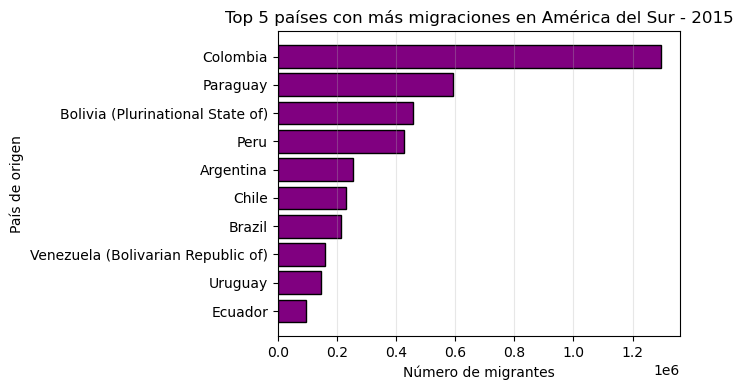

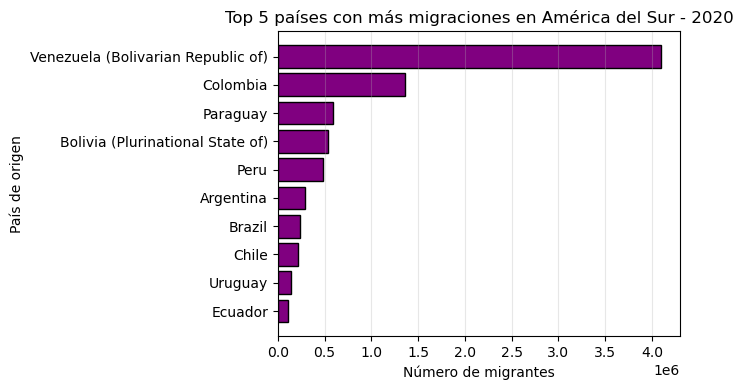

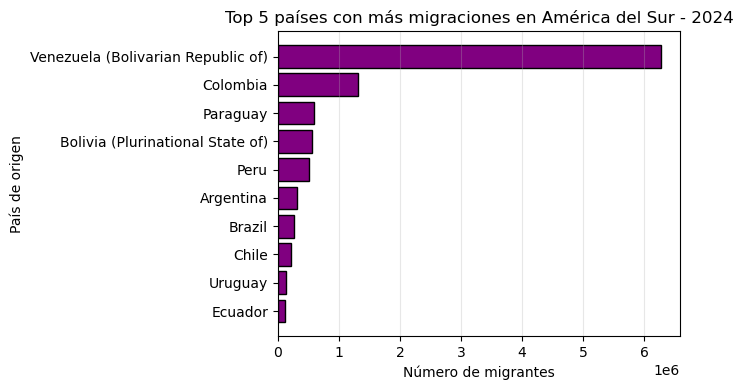

In [93]:
anios = ['1990', '1995', '2000', '2005', '2010', '2015', '2020', '2024']

# Agrupamos por país de origen y sumamos las migraciones dentro del continente
migraciones_por_origen = migraciones_sur.groupby("origen")[anios].sum().reset_index()

for anio in anios:
    top5 = migraciones_por_origen.sort_values(by=anio, ascending=False).head(10)
    
    plt.figure(figsize=(7, 4))
    plt.barh(top5["origen"], top5[anio], color="purple", edgecolor="black")
    
    plt.title(f"Top 5 países con más migraciones en América del Sur - {anio}")
    plt.xlabel("Número de migrantes")
    plt.ylabel("País de origen")
    plt.gca().invert_yaxis()  
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()


## Pasar a datos para graficar en Gephi (América del Sur)

In [94]:
import pandas as pd

# ---------------------------------------------------
# 1️⃣ Crear nodos (países)
# ---------------------------------------------------
#nodos_origen = migraciones_sur[['codigo_origen', 'origen']].rename(
#    columns={'codigo_origen': 'Id', 'origen': 'Label'}
#)
#nodos_destino = migraciones_sur[['codigo_destino', 'destino']].rename(
#    columns={'codigo_destino': 'Id', 'destino': 'Label'}
#)

# Combinar y eliminar duplicados
#nodos = pd.concat([nodos_origen, nodos_destino]).drop_duplicates(subset='Id')

# Guardar nodos
#nodos.to_csv('nodes.csv', index=False)

# ---------------------------------------------------
# 2️⃣ Crear aristas (edges) usando la columna 2024
# ---------------------------------------------------
#edges = migraciones_sur[['codigo_origen', 'codigo_destino', '2024']].rename(
#    columns={'codigo_origen': 'Source', 'codigo_destino': 'Target', '2024': 'Weight'}
#)

# Eliminar filas con peso 0 o NaN
#edges = edges[edges['Weight'] > 0]

# Guardar aristas
#edges.to_csv('edges.csv', index=False)

#print("✅ Archivos 'nodes.csv' y 'edges.csv' listos para importar en Gephi.")

---

# Graphi general de todos los países

In [95]:
# === Crear aristas (edges) solo para el año 2024 ===
df = migra_paises

edges = df[["origen", "destino", "2024"]].copy()
edges = edges.rename(columns={
    "origen": "source",
    "destino": "target",
    "2024": "weight"
})

# Eliminar filas sin peso o con peso cero
edges = edges[edges["weight"] > 0]

# Guardar aristas
edges.to_csv("aristas.csv", index=False)

# === Crear nodos (nodes) ===
# Unir todos los países únicos (tanto origen como destino)
import pandas as pd

paises = pd.unique(edges[["source", "target"]].values.ravel())

nodes = pd.DataFrame({
    "id": paises,
    "label": paises
})

# Guardar nodos
nodes.to_csv("nodos.csv", index=False)

print("✅ Archivos generados correctamente:")
print("- aristas_mundial.csv")
print("- nodos_mundial.csv")


✅ Archivos generados correctamente:
- aristas_mundial.csv
- nodos_mundial.csv


---

# Cada uno de los continentes

In [96]:
emigraciones_2024 = (
    migraciones_sur.groupby("origen")["2024"]
    .sum()
    .reset_index()
    .rename(columns={"origen": "pais", "2024": "emigraciones_2024"})
)

# Calcular inmigraciones (entradas) en 2024
inmigraciones_2024 = (
    migraciones_sur.groupby("destino")["2024"]
    .sum()
    .reset_index()
    .rename(columns={"destino": "pais", "2024": "inmigraciones_2024"})
)

# Combinar ambas tablas
migraciones_2024 = pd.merge(emigraciones_2024, inmigraciones_2024, on="pais", how="outer").fillna(0)

# Calcular el saldo migratorio (inmigrantes - emigrantes)
migraciones_2024["saldo_migratorio"] = (
    migraciones_2024["inmigraciones_2024"] - migraciones_2024["emigraciones_2024"]
)

# Ordenar los resultados de mayor a menor.
migraciones_2024 = migraciones_2024.sort_values("emigraciones_2024", ascending=False) # Esto se puede cambiar con inmigraciones...

# Mostrar las primeras filas
display(migraciones_2024.head(10))

,pais,emigraciones_2024,inmigraciones_2024,saldo_migratorio
13,Venezuela (Bolivarian Republic of),6268352,993742,-5274610
4,Colombia,1317258,2951953,1634695
9,Paraguay,587559,158129,-429430
1,Bolivia (Plurinational State of),561026,122269,-438757
10,Peru,516754,1719519,1202765
0,Argentina,319494,1550287,1230793
2,Brazil,267261,785896,518635
3,Chile,211718,1183478,971760
12,Uruguay,135451,104997,-30454
5,Ecuador,124033,672547,548514


In [97]:
sur_america = ["Argentina","Bolivia (Plurinational State of)","Brazil","Chile","Colombia","Ecuador","Guyana","Paraguay","Peru","Suriname","Uruguay","Venezuela (Bolivarian Republic of)","French Guiana","Falkland Islands (Malvinas)"]

centroamerica_caribe = ["Belize","Costa Rica","Cuba","Dominican Republic","El Salvador","Guatemala","Honduras","Nicaragua","Panama","Haiti","Jamaica","Trinidad and Tobago","Puerto Rico"]

norte_america = ["Canada","United States of America","Mexico","Greenland","Bermuda"]

africa = ["Algeria","Angola","Botswana","Burundi","Cameroon","Congo","Democratic Republic of the Congo","Egypt","Ethiopia","Ghana","Kenya","Libya","Madagascar","Malawi","Morocco","Mozambique","Namibia","Nigeria","South Africa","Sudan","Tanzania","Tunisia","Uganda","Zambia","Zimbabwe"]

asia = ["China","India","Japan","Republic of Korea","Indonesia","Pakistan","Iran (Islamic Republic of)","Saudi Arabia","Türkiye","Philippines","Thailand","Viet Nam","Malaysia","Bangladesh","Nepal","Sri Lanka","United Arab Emirates"]

europa = ["Spain","France","Germany","Italy","United Kingdom","Portugal","Netherlands","Belgium","Switzerland","Austria","Sweden","Norway","Denmark","Finland","Poland","Czechia","Greece","Hungary","Ireland","Romania","Bulgaria","Serbia","Croatia","Slovakia","Slovenia","Ukraine","Belarus","Lithuania","Latvia","Estonia"]

oceania = ["Australia","New Zealand","Fiji","Papua New Guinea","Samoa","Tonga","Solomon Islands","Vanuatu","Micronesia (Federated States of)","Kiribati","Nauru","Palau"]

In [98]:
# América del Sur
migraciones_sur = migraciones[migraciones['origen'].isin(sur_america) & migraciones['destino'].isin(sur_america)]
display(migraciones_sur)

# América Central y Caribe
migraciones_centro = migraciones[migraciones['origen'].isin(centroamerica_caribe) & migraciones['destino'].isin(centroamerica_caribe)]
display(migraciones_centro)

# América del Norte
migraciones_norte = migraciones[migraciones['origen'].isin(norte_america) & migraciones['destino'].isin(norte_america)]
display(migraciones_norte)

# África
migraciones_africa = migraciones[migraciones['origen'].isin(africa) & migraciones['destino'].isin(africa)]
display(migraciones_africa)

# Asia
migraciones_asia = migraciones[migraciones['origen'].isin(asia) & migraciones['destino'].isin(asia)]
display(migraciones_asia)

# Europa
migraciones_europa = migraciones[migraciones['origen'].isin(europa) & migraciones['destino'].isin(europa)]
display(migraciones_europa)

# Oceanía
migraciones_oceania = migraciones[migraciones['origen'].isin(oceania) & migraciones['destino'].isin(oceania)]
display(migraciones_oceania)


,codigo_origen,origen,codigo_destino,destino,1990,1995,2000,2005,2010,2015,2020,2024
24341,68,Bolivia (Plurinational State of),32,Argentina,161850,190118,223303,273555,340770,342431,339423,337017
24342,76,Brazil,32,Argentina,38851,36975,35180,37254,41070,44633,48454,51527
24343,152,Chile,32,Argentina,214148,213391,212646,203538,191797,172916,155359,141348
24344,170,Colombia,32,Argentina,12,12,15,3645,16289,26314,39991,53163
24345,218,Ecuador,32,Argentina,12,14,1049,2905,4680,6197,8066,9704
...,...,...,...,...,...,...,...,...,...,...,...,...
25553,328,Guyana,862,Venezuela (Bolivarian Republic of),4601,5577,6698,7511,8510,9149,8624,8227
25554,600,Paraguay,862,Venezuela (Bolivarian Republic of),359,294,239,226,217,214,200,191
25555,604,Peru,862,Venezuela (Bolivarian Republic of),29635,32973,36348,39846,44126,47007,44319,42281
25556,740,Suriname,862,Venezuela (Bolivarian Republic of),106,80,61,54,48,46,43,41


,codigo_origen,origen,codigo_destino,destino,1990,1995,2000,2005,2010,2015,2020,2024
21884,214,Dominican Republic,192,Cuba,267,203,146,87,49,27,14,10
21886,332,Haiti,192,Cuba,2063,1564,1226,607,284,126,54,38
21887,388,Jamaica,192,Cuba,656,497,353,218,129,71,38,27
21888,630,Puerto Rico,192,Cuba,272,206,155,84,44,21,10,7
21890,320,Guatemala,192,Cuba,153,116,75,56,41,27,18,13
...,...,...,...,...,...,...,...,...,...,...,...,...
23966,188,Costa Rica,591,Panama,3919,4155,4654,5121,6629,7760,9320,14218
23967,222,El Salvador,591,Panama,2396,2146,2032,2173,2756,3225,4147,6326
23968,320,Guatemala,591,Panama,376,473,600,894,1372,1606,1925,2937
23969,340,Honduras,591,Panama,638,715,838,963,1284,1504,1797,2741


,codigo_origen,origen,codigo_destino,destino,1990,1995,2000,2005,2010,2015,2020,2024
23755,124,Canada,484,Mexico,4202,4947,5836,6815,7983,10031,12587,14431
23756,840,United States of America,484,Mexico,225566,280285,353209,511789,731017,768225,799179,823502
25822,124,Canada,60,Bermuda,2295,2437,2183,2211,2233,2154,2032,2076
25823,840,United States of America,60,Bermuda,3468,3454,2916,3157,3428,3572,3606,3685
25985,484,Mexico,124,Canada,18064,25058,34296,48143,79532,94003,91284,103620
26000,840,United States of America,124,Canada,249582,245474,238914,248125,304650,334930,267441,256571
26045,124,Canada,304,Greenland,12,10,11,23,10,15,14,14
26046,840,United States of America,304,Greenland,29,26,26,27,30,39,38,37
26149,484,Mexico,840,United States of America,4506017,7065241,9245920,11171400,11895927,11938908,11177052,11279561
26161,124,Canada,840,United States of America,880627,1017197,965513,950086,928127,955022,931908,950387


,codigo_origen,origen,codigo_destino,destino,1990,1995,2000,2005,2010,2015,2020,2024
6458,404,Kenya,108,Burundi,186,216,202,502,847,1032,1226,1377
6460,800,Uganda,108,Burundi,1833,1546,949,805,731,891,1058,1188
6463,180,Democratic Republic of the Congo,108,Burundi,36654,41447,37951,99099,147611,175768,199585,224091
6584,108,Burundi,231,Ethiopia,0,10,16,74,97,106,131,130
6587,404,Kenya,231,Ethiopia,190,8600,2703,596,4350,4422,5372,5564
...,...,...,...,...,...,...,...,...,...,...,...,...
9361,818,Egypt,288,Ghana,21,21,23,32,32,39,43,48
9362,729,Sudan,288,Ghana,18,18,20,28,21,25,27,30
9373,566,Nigeria,288,Ghana,14876,14826,16584,28321,57056,70214,80652,90111
9919,120,Cameroon,566,Nigeria,10242,10384,10943,21748,22214,26893,52489,56288


,codigo_origen,origen,codigo_destino,destino,1990,1995,2000,2005,2010,2015,2020,2024
10929,392,Japan,156,China,33057,38903,46301,55111,64702,50193,37470,40436
10931,410,Republic of Korea,156,China,60637,71176,84711,100830,118141,86238,60578,65073
10934,50,Bangladesh,156,China,327,394,470,558,684,1480,3081,3569
10936,356,India,156,China,7571,8879,10567,12578,14726,10522,7235,7765
10937,364,Iran (Islamic Republic of),156,China,555,664,792,943,1119,1181,1201,1331
...,...,...,...,...,...,...,...,...,...,...,...,...
13785,360,Indonesia,784,United Arab Emirates,46445,67397,91456,119309,199195,250877,262762,298351
13786,608,Philippines,784,United Arab Emirates,59910,90400,124993,198805,352872,444426,465483,528527
13787,764,Thailand,784,United Arab Emirates,2221,2810,3538,4750,8011,10089,10565,11996
13794,682,Saudi Arabia,784,United Arab Emirates,463,989,1556,2349,4112,5178,5422,6157


,codigo_origen,origen,codigo_destino,destino,1990,1995,2000,2005,2010,2015,2020,2024
14449,100,Bulgaria,112,Belarus,30,47,63,61,58,61,59,58
14450,203,Czechia,112,Belarus,83,91,99,95,91,96,93,92
14451,348,Hungary,112,Belarus,291,323,354,341,327,342,335,331
14452,616,Poland,112,Belarus,235,365,495,476,456,478,470,465
14454,642,Romania,112,Belarus,10,17,23,22,20,23,21,21
...,...,...,...,...,...,...,...,...,...,...,...,...
20853,40,Austria,756,Switzerland,54982,54938,55280,58607,59101,60047,58683,57640
20854,56,Belgium,756,Switzerland,8618,9619,10804,12692,14275,16232,17676,19211
20855,250,France,756,Switzerland,99313,105573,112955,126528,135578,156030,175221,195100
20856,276,Germany,756,Switzerland,234879,250441,268635,300781,323003,349435,359069,371816


,codigo_origen,origen,codigo_destino,destino,1990,1995,2000,2005,2010,2015,2020,2024
26900,554,New Zealand,36,Australia,263301,304515,366287,424120,520509,575163,583769,588088
26902,242,Fiji,36,Australia,33513,39284,46792,54816,63911,72652,76355,83435
26904,598,Papua New Guinea,36,Australia,24941,26204,25625,26907,30064,33592,33732,34316
26905,90,Solomon Islands,36,Australia,1067,1255,1395,1640,1944,2295,2886,7161
26906,548,Vanuatu,36,Australia,921,1002,1057,1183,1283,1390,3750,10208
26909,296,Kiribati,36,Australia,350,395,439,485,598,645,903,1585
26910,520,Nauru,36,Australia,439,481,494,570,630,688,730,782
26916,882,Samoa,36,Australia,7863,10039,13171,16595,20554,27802,33647,38964
26918,776,Tonga,36,Australia,7089,7731,8114,8716,10092,11862,15295,19464
27005,36,Australia,554,New Zealand,48723,53903,55949,61754,62683,68984,80634,89129


In [99]:
import networkx as nx

# Función para filtrar migraciones por continente
def filtrar_migraciones_por_continente(migraciones, continentes_dict):
    """
    Crea un diccionario con los DataFrames de migraciones por continente.
    Ejemplo de salida: migraciones_por_continente["sur"] = migraciones dentro de Sudamérica
    """
    migraciones_por_continente = {}
    for nombre, paises in continentes_dict.items():
        df_filtrado = migraciones[
            migraciones['origen'].isin(paises) & 
            migraciones['destino'].isin(paises)
        ]
        migraciones_por_continente[nombre] = df_filtrado
    return migraciones_por_continente


# crear el grafo
def crear_grafo_migraciones(df_continente, coordenadas):
    """
    Crea un grafo dirigido con pesos (cantidad de migrantes) 
    a partir del DataFrame de migraciones de un continente.
    """
    grafo = nx.DiGraph()

    for origen, destino in zip(df_continente['origen'], df_continente['destino']):
        migrantes = df_continente.loc[
            (df_continente['origen'] == origen) & 
            (df_continente['destino'] == destino),
            '2024'
        ].sum()
        
        if migrantes != 0:
            grafo.add_node(origen)
            grafo.add_node(destino)
            grafo.add_edge(origen, destino, weight=migrantes)

# Generar posiciones geográficas para los nodos
    pos = {}
    for nodo in grafo.nodes():
        lat, lon, *_ = coordenadas[nodo]  
        pos[nodo] = (lon, lat)

    return grafo, pos


# definir los países por continente 
continentes_dict = {
    "sur": sur_america,
    "norte": norte_america,
    "europa": europa,
    "asia": asia,
    "africa": africa,
    "oceania": oceania
}


# Generar los DataFrames por continente 
migraciones_por_continente = filtrar_migraciones_por_continente(migraciones, continentes_dict)

grafos = {}
posiciones = {}

for nombre, df in migraciones_por_continente.items():
    g, p = crear_grafo_migraciones(df, coordenadas)
    grafos[nombre] = g
    posiciones[nombre] = p


# Caso sur América (ejemplo)
print("Grafo de Sudamérica:")
print(f" Nodos: {grafos['sur'].number_of_nodes()}")
print(f" Aristas: {grafos['sur'].number_of_edges()}")

Grafo de Sudamérica:
 Nodos: 14
 Aristas: 103


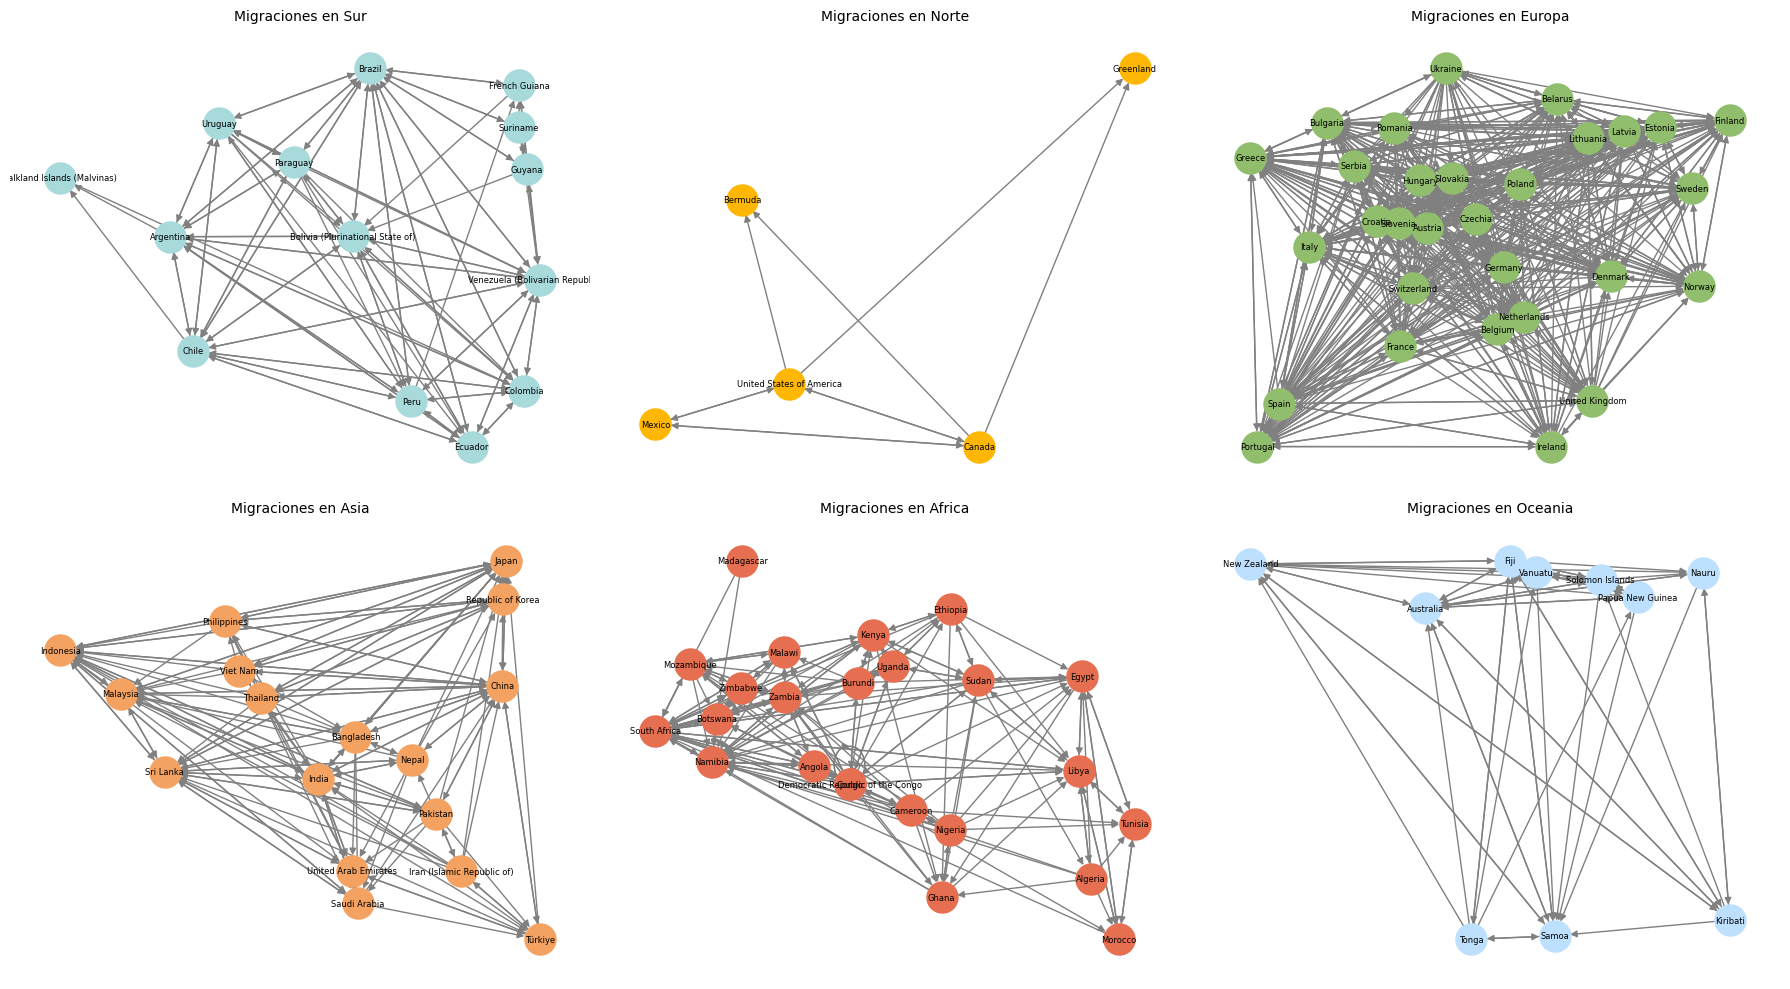

In [100]:
import matplotlib.pyplot as plt
import math

colores_continentes = {
    "sur": "#a8dadc",     
    "norte": "#ffb703",   
    "europa": "#90be6d",  
    "asia": "#f4a261",    
    "africa": "#e76f51",   
    "oceania": "#bde0fe"  
}

n = len(grafos)
filas = math.ceil(n / 3)
columnas = 3

fig, axes = plt.subplots(filas, columnas, figsize=(18, 10))
axes = axes.flatten()

for i, (nombre, grafo) in enumerate(grafos.items()):
    ax = axes[i]
    nx.draw(
        grafo,
        posiciones[nombre],
        ax=ax,
        with_labels=True,
        node_size=500,
        node_color=colores_continentes.get(nombre, "#cccccc"),
        font_size=6,
        arrows=True,
        edge_color="gray",
        width=1.0
    )
    ax.set_title(f"Migraciones en {nombre.capitalize()}", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor("#f8f9fa")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()
